The complete explanation for this notebook is available at https://youranalystbuddy.com/evaluate-binary-classification-models/

## Evaluate binary classification models

This notebook introduces some basic metrics for evaluation of binary classification models.

### Data introduction

In this example, I use a modified version of the Maternal Health Risk data. You can find the original dataset in https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set. 

The target is <b>AtRisk</b>

### Loading data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('Maternal Health Risk Data Set.csv')
data.head(n=2)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,AtRisk
0,16,120,75,7.9,98.0,70,0
1,16,120,75,7.9,98.0,70,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   AtRisk       1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


### Train/Test Split 

In [3]:
from sklearn.model_selection import train_test_split

target = 'AtRisk'
X = data.drop(target, axis=1)
y = data[target]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

### Preliminary Analysis

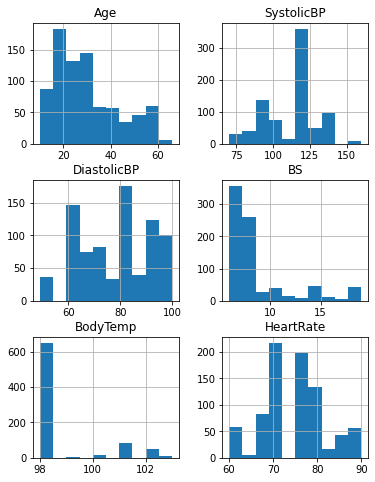

In [4]:
import matplotlib.pyplot as plt
trainX.hist(figsize=(6,8), bins=10)
plt.show()

### Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

trainX_prc = scaler.fit_transform(trainX)
testX_prc = scaler.transform(testX)  

### Modeling

We will just use a L2 logistic model here.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1 , 5, 10, 50, 100]}]

#the default is l2 anyway, but we can specify it so that the code is clear
#logistic regression is also trained iteratively, we can increase max_iter if you see some warning from sklearn
logistic = LogisticRegression(penalty='l2', max_iter=5000)

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                50, 100]}],
             return_train_score=True, scoring='accuracy')

We will extract the best model for convenience

In [7]:
best_logistic = grid_search.best_estimator_

then we get CV prediction for the training data and regular prediction for testing data. We also create a 0-prediction, everything as 0 for testing

In [8]:
from sklearn.model_selection import cross_val_predict

trainY_pred = cross_val_predict(best_logistic, trainX_prc, trainY, cv=5)
trainY_0 = np.zeros(trainY.shape[0])
testY_pred = best_logistic.predict(testX_prc)

## Evaluation metrics

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### $accuracy = \dfrac{TP+TN}{TP+FP+FN+TN}$

In [10]:
accuracy_score(trainY, trainY_pred)

0.8545006165228114

In [11]:
accuracy_score(trainY, trainY_0)

0.7324290998766955

In [12]:
accuracy_score(testY, testY_pred)

0.8275862068965517

<h3> Confusion Matrix </h3>

Confusion matrix not only shows how many instances is predicted correctly, it also shows the number of mispredicted instances between classes

In binary classification, the matrix has four values: 
- actual 1, predicted 1: True Positive - TP
- actual 0, predicted 1: False Positive - FP
- actual 1, predicted 0: False Negative - FN
- actual 0, predicted 0: True Negative - TN

To generate a confusion matrix in sklearn, we need the predicted values for the data. We will use the prediction from 5-fold cross validation to avoid overfitting. This is done with <b>cross_val_predict()</b>

Then generate the matrix is very easy, we use <b>confusion_matrix()</b> and feed it with the true labels and predicted labels. In the matrix of binary classification, the count of true negatives is at cell [0,0], false negatives is at cell [1,0], true positives is at cell [1,1] and false positives is at cell [0,1].

In [13]:
confusion_matrix(trainY, trainY_pred)

array([[569,  25],
       [ 93, 124]], dtype=int64)

In [14]:
confusion_matrix(trainY, trainY_0)

array([[594,   0],
       [217,   0]], dtype=int64)

In [15]:
confusion_matrix(testY, testY_pred)

array([[141,   7],
       [ 28,  27]], dtype=int64)

<h3> $precision = \dfrac{TP}{TP+FP}$ </h3>

Precision measures how many rows predicted as positive are indeed positive. We can use precision_score provided by sklearn

In [16]:
precision_score(trainY, trainY_pred)

0.8322147651006712

In [17]:
precision_score(trainY, trainY_0)

C:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [18]:
precision_score(testY, testY_pred)

0.7941176470588235

<h3> $recall = \dfrac{TP}{TP+FN}$ </h3>

Recall measures how many rows of the TRUE class are correctly predicted. We will use recall_score()

In [19]:
recall_score(trainY, trainY_pred)

0.5714285714285714

In [20]:
recall_score(trainY, trainY_0)

0.0

In [21]:
recall_score(testY, testY_pred)

0.4909090909090909

<h3> $F1=\dfrac{2\times precision \times recall}{precision + recall}$ </h3>

A measurement combined from precision and recall. Higher F1 mean better models. We will use f1_score()

In [22]:
f1_score(trainY, trainY_pred)

0.6775956284153005

In [23]:
f1_score(trainY, trainY_0)

0.0

In [24]:
f1_score(testY, testY_pred)

0.6067415730337079